In [1]:
!pwd

/Users/etretiakov/src/GlobalStructure


In [2]:
%load_ext watermark

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
import hdbscan

In [5]:
from pathlib import Path

In [6]:
data = pd.read_csv('1_Raw/MitoBreakDB_12122019.csv')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Deletions                        1313 non-null   object
 1   5' breakpoint                    1313 non-null   object
 2   3' breakpoint                    1313 non-null   object
 3   Deletion length - bp             1313 non-null   object
 4   Deletion of replication origins  1313 non-null   object
 5   Location of the deleted region   1313 non-null   object
 6   Single mtDNA deletions           153 non-null    object
 7   Multiple mtDNA deletions         331 non-null    object
 8   Healthy tissues                  308 non-null    object
 9   Parkinson Disease                26 non-null     object
 10  Inclusion Body Myositis          48 non-null     object
 11  Tumour                           94 non-null     object
 12  Other clinical features          5

In [8]:
data.head()

Deletions 5' breakpoint 3' breakpoint Deletion length - bp  \
0   83:16095            83         16095                16011   
1    105:112           105           112                    6   
2  114:12305           114         12305                12190   
3  167:16223           167         16223                16055   
4   174:3623           174          3623                 3448   

  Deletion of replication origins       Location of the deleted region  \
0                       OH and OL  Removing full minor and part o(...)   
1                            None                 Inside the major arc   
2                       OH and OL  Removing full minor and part o(...)   
3                       OH and OL  Removing full minor and part o(...)   
4                              OH  Removing part of minor and maj(...)   

  Single mtDNA deletions             Multiple mtDNA deletions  \
0                    NaN  Patients with pathogenic MGME1(...)   
1                    NaN                                  NaN   
2                    NaN  Patients with pathogenic MGME1(...)   
3                    NaN  Patients with pathogenic MGME1(...)   
4                    NaN                                  NaN   

                 Healthy tissues Parkinson Disease Inclusion Body Myositis  \
0                            NaN               NaN                     NaN   
1  Normal tissues (polymorphism)               NaN                     NaN   
2                            NaN               NaN                     NaN   
3                            NaN               NaN                     NaN   
4                            NaN               NaN                     NaN   

  Tumour              Other clinical features References  
0    NaN                                  NaN      [327]  
1    NaN                                  NaN    [53-57]  
2    NaN                                  NaN      [327]  
3    NaN                                  NaN      [327]  
4    NaN  Skeletal muscle biopsies and �(...)      [329]

In [9]:
breakpoints = data[["5' breakpoint", "3' breakpoint"]][:-1].copy()

In [10]:
breakpoints.columns = ['five', 'three']

breakpoints.five = breakpoints.five.astype(int)
breakpoints.three = breakpoints.three.astype(int)

breakpoints.loc[breakpoints.five < 110, 'five'] += 16569
breakpoints.loc[breakpoints.three < 110, 'three'] += 16569

breakpoints = breakpoints[(breakpoints.five > 5781)&(breakpoints.three > 5781)]

<Axes: xlabel='five', ylabel='three'>

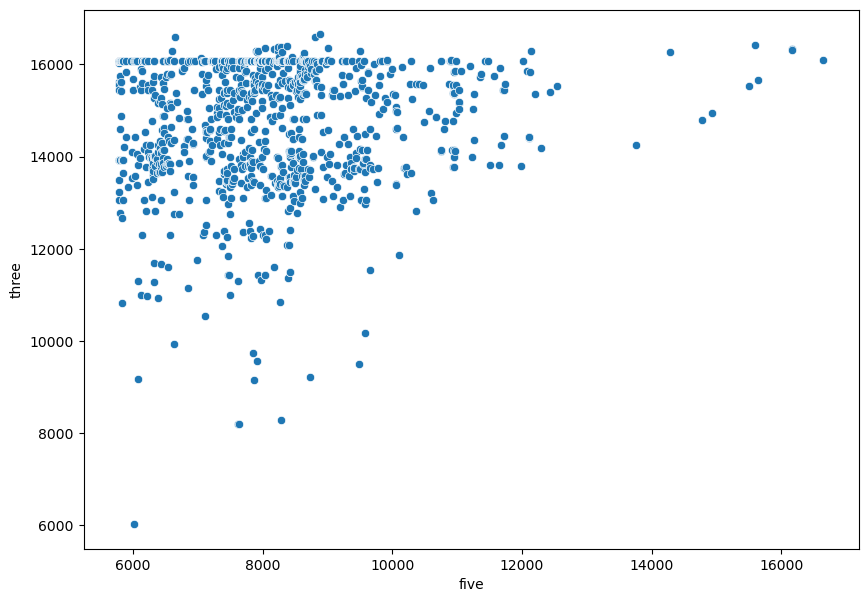

In [11]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=breakpoints, x='five', y='three')

In [12]:
def clustering(breakpoints, graph_fn = 'clusters.svg'):
    clusterer = hdbscan.HDBSCAN(cluster_selection_epsilon = 50
                            #, cluster_selection_method='leaf'
                            , min_samples=10                            
                           )
    clusters  =clusterer.fit_predict(breakpoints)
    colors = sns.color_palette('hls', len(np.unique(clusters))-1)
    sns.set_style('white')
    plt.figure(figsize=(10,7))
    plt.gca().invert_yaxis()
    x = breakpoints.five[clusters == -1]
    y = breakpoints.three[clusters == -1]
    plt.scatter(x, y, color='black', alpha=0.5, s=5)

    for c, color in list(zip(range(0, np.max(clusters)+1), colors)):
        x = breakpoints.five[clusters == c]
        y = breakpoints.three[clusters == c]
        plt.scatter(x, y, color=color, s=100)
    plt.xlabel("5'")
    plt.ylabel("3'")
    plt.title('Clusters')
    plt.savefig( graph_fn)# 
    return breakpoints, clusters

In [13]:
figures_path = Path('3_Results/')

# Clusters before deletion of the "hairpin"
(3' at 16000)

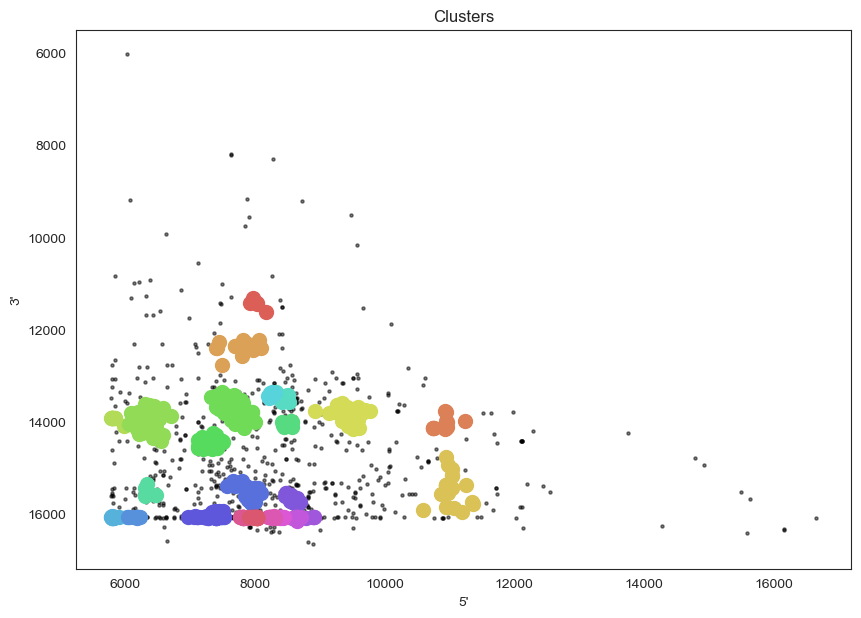

In [14]:
data, clusters = clustering(breakpoints.copy(), str(figures_path / 'clusters_with_spike.svg'))

### Plot clusters separately:

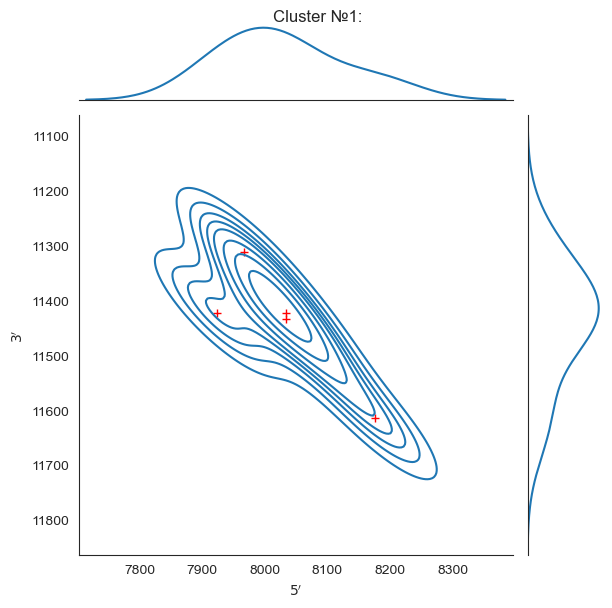

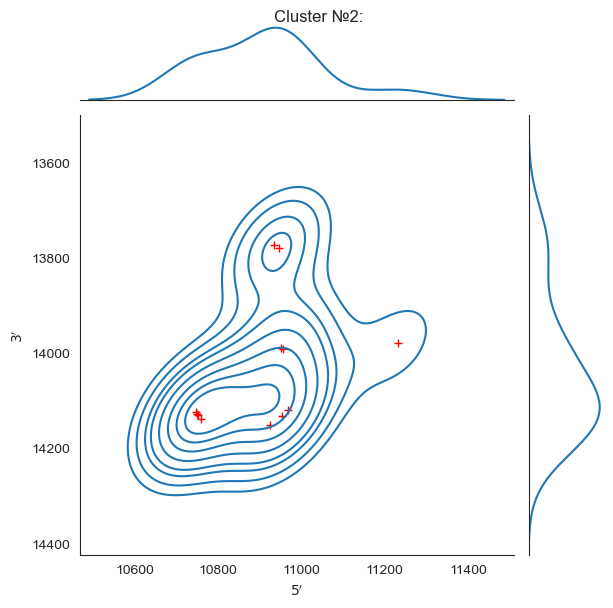

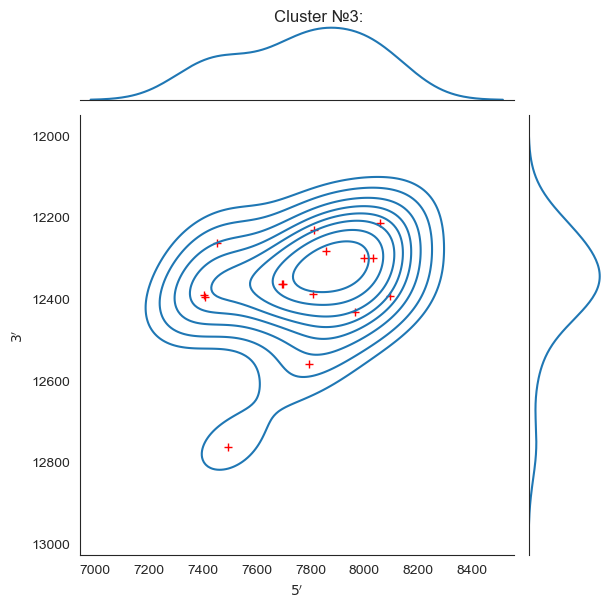

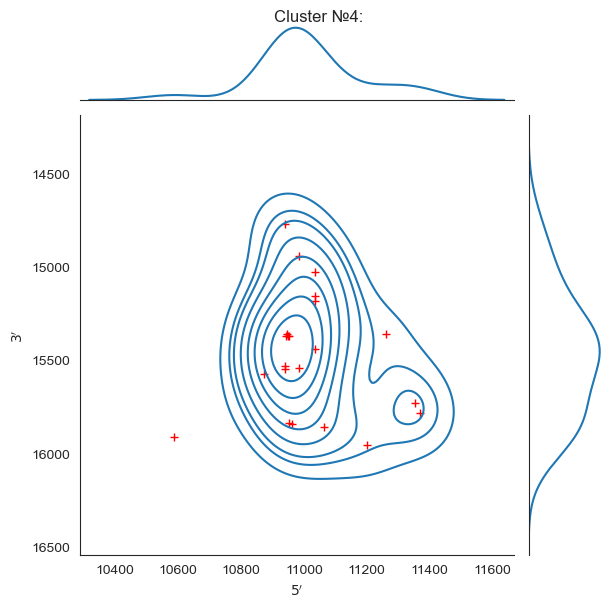

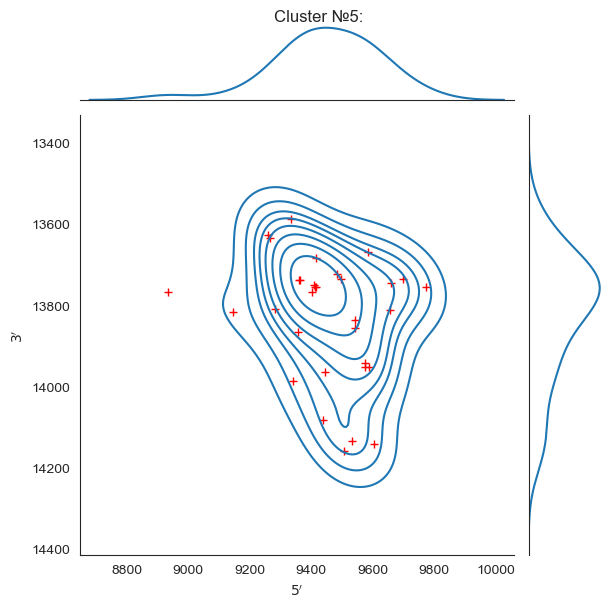

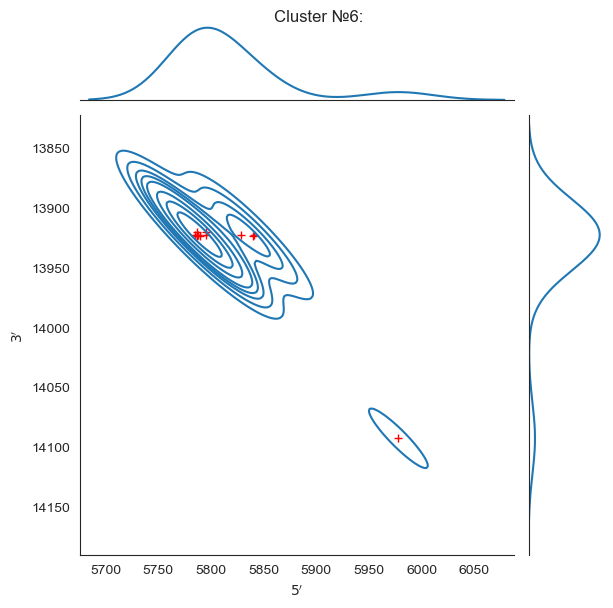

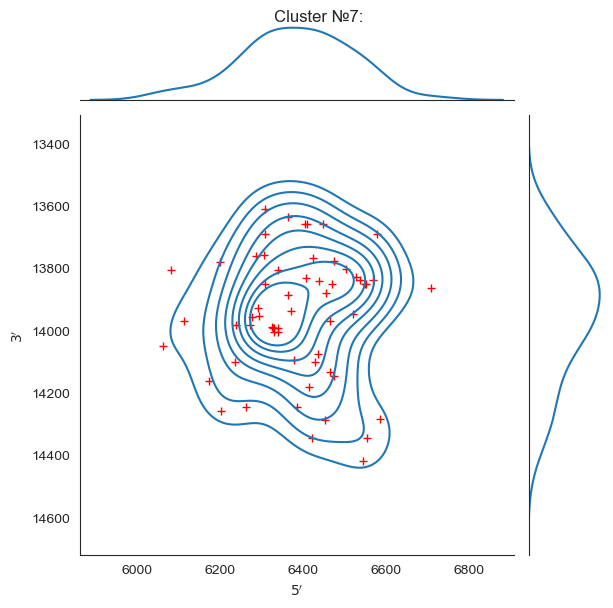

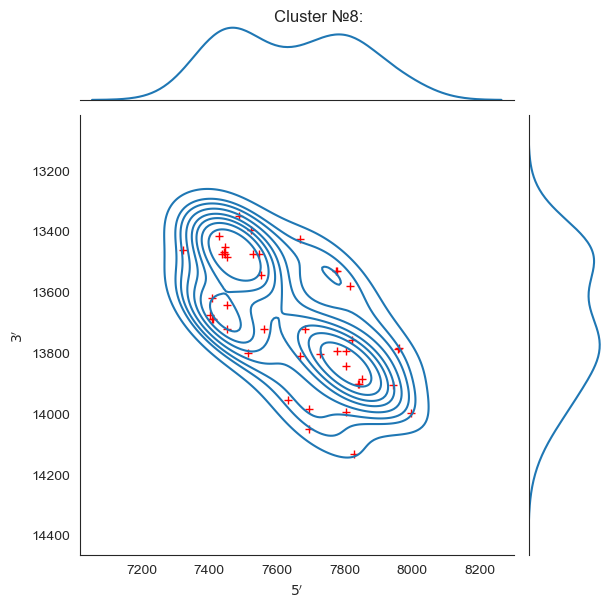

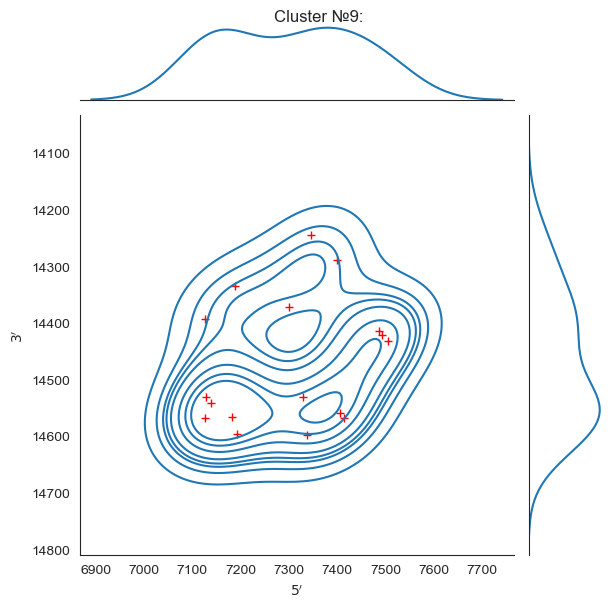

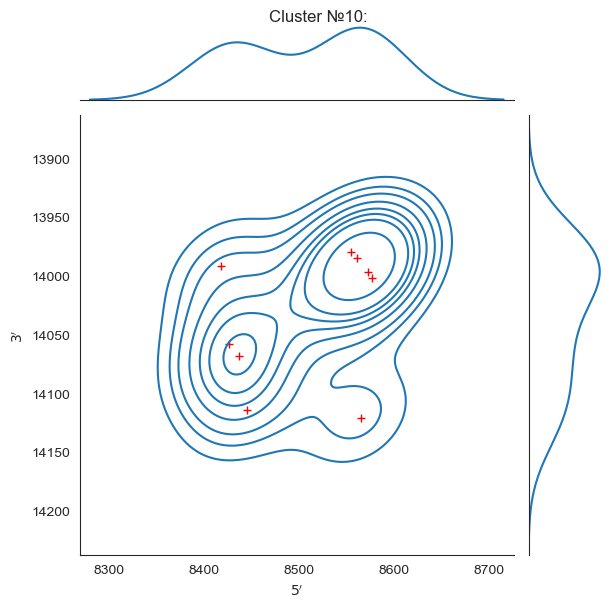

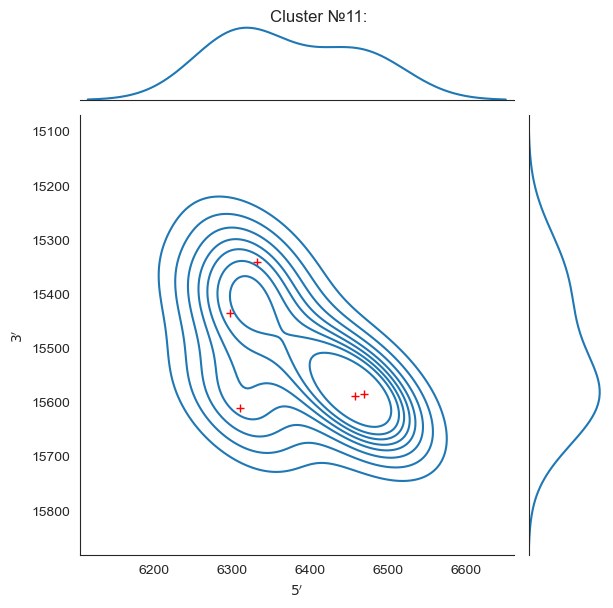

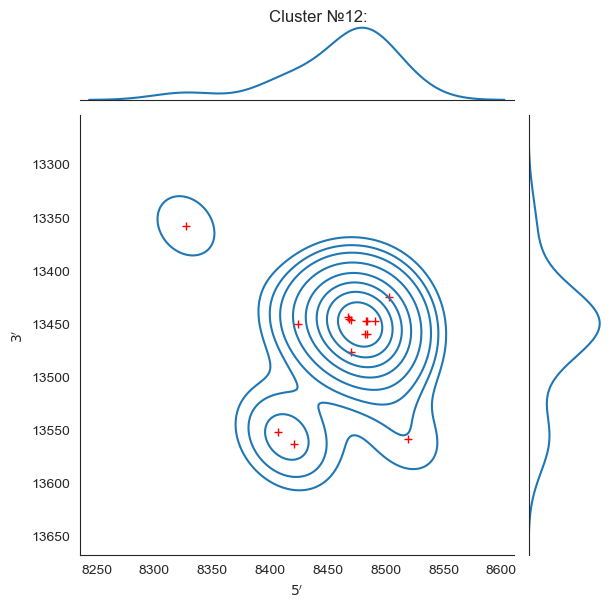

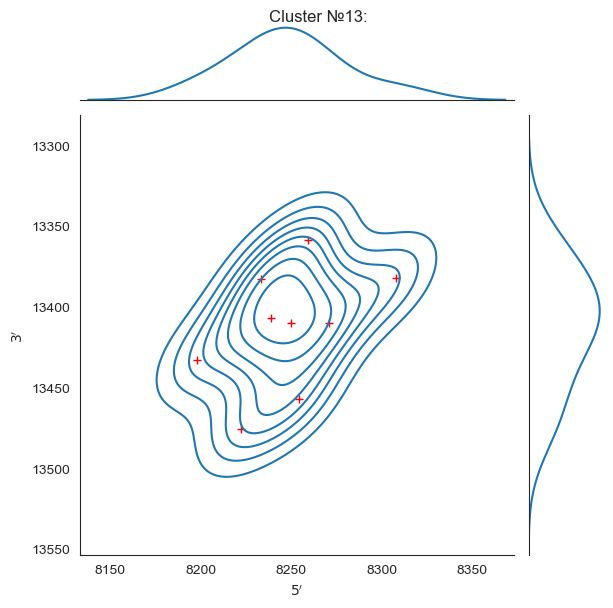

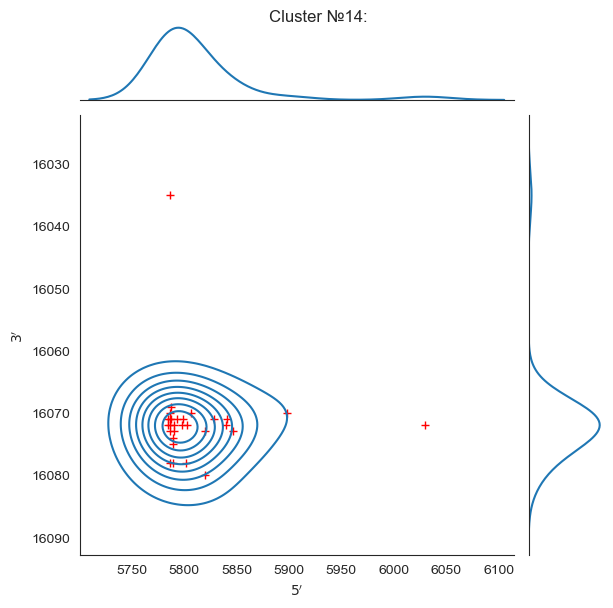

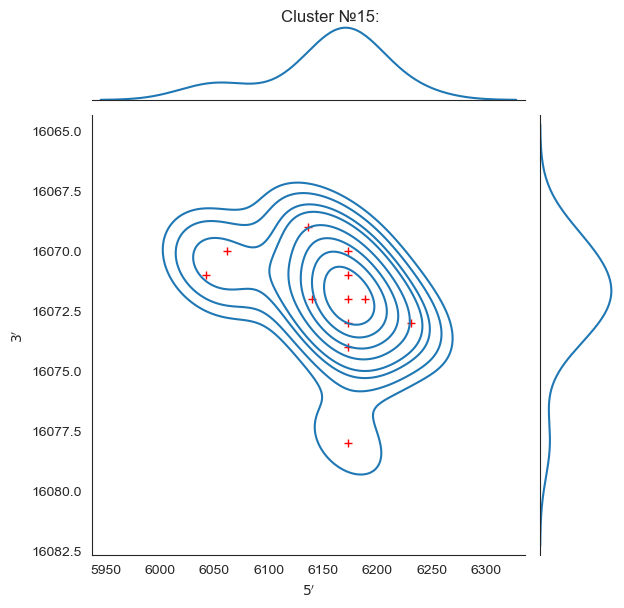

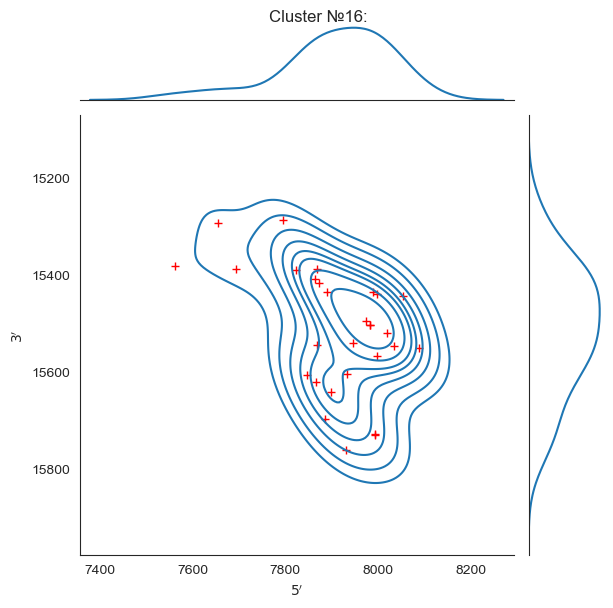

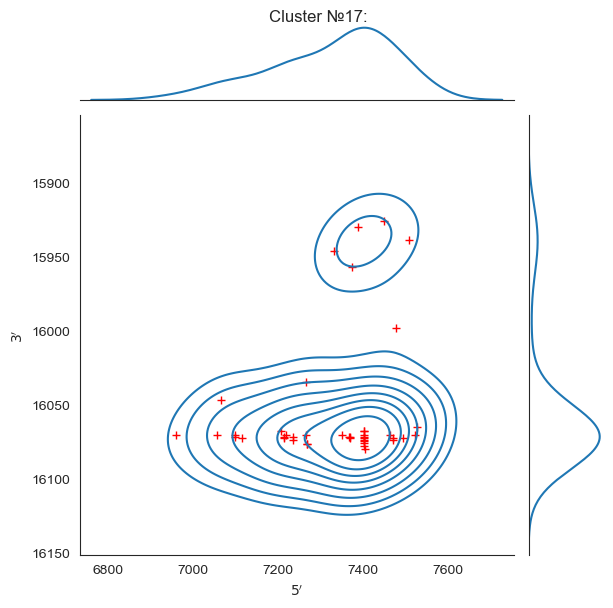

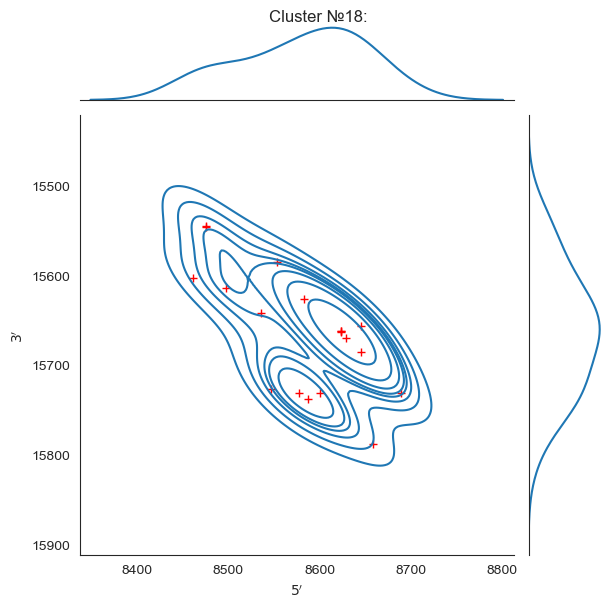

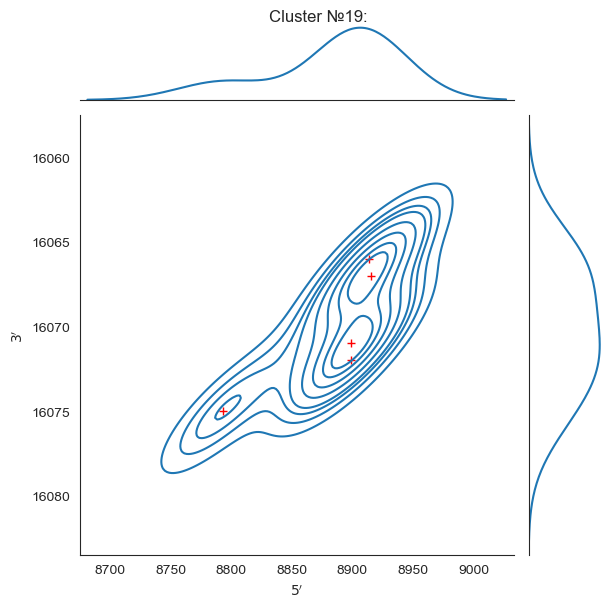

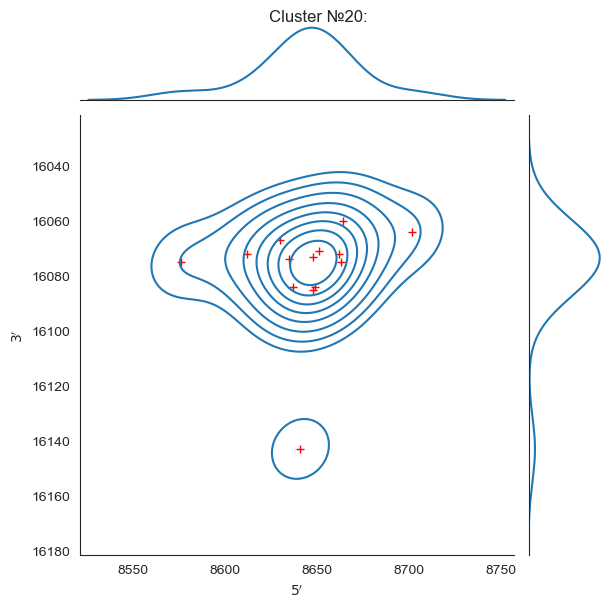

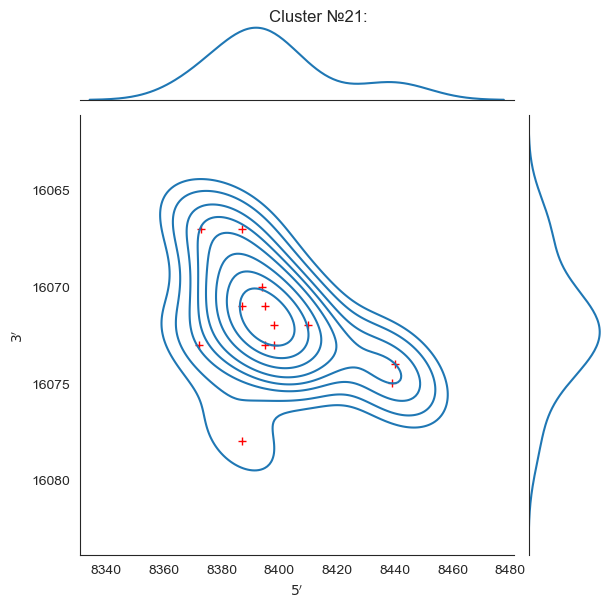

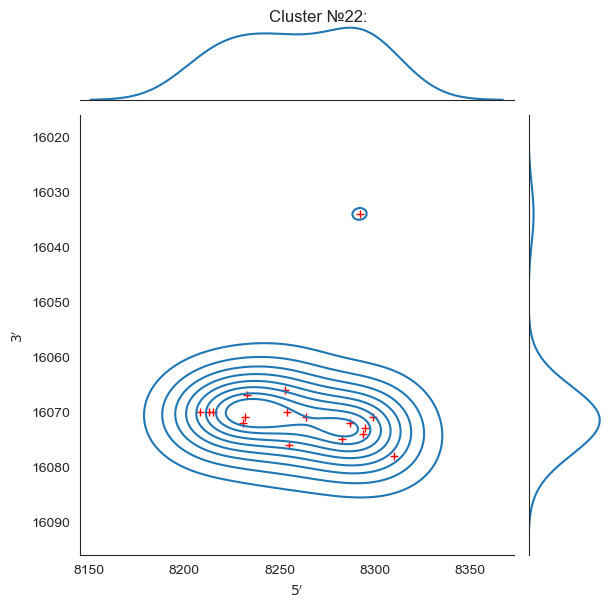

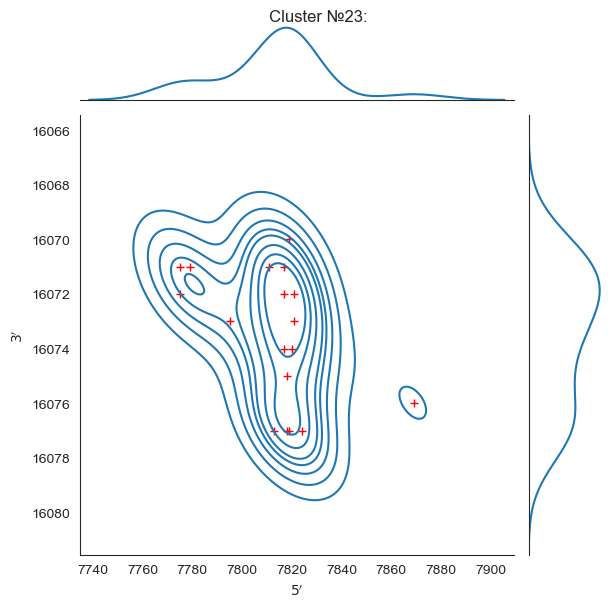

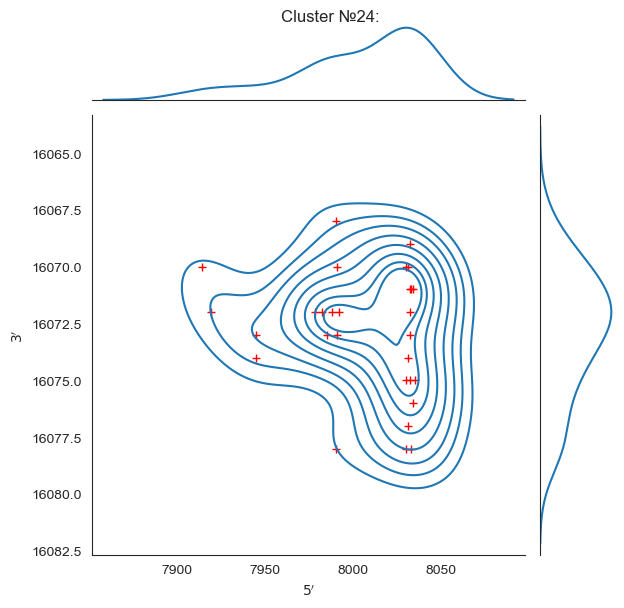

In [15]:
for c in np.unique(clusters[clusters >=0]):
    cluster_data = data[clusters == c]    
    
#     f, ax = plt.subplots(figsize=(6, 6))
#     sns.kdeplot(cluster_data.five, cluster_data.three, ax=ax)
#     #sns.jointplot(cluster_data.five, cluster_data.three, ax=ax)
#     sns.rugplot(cluster_data.five, color="g", ax=ax)
#     sns.rugplot(cluster_data.three, vertical=True, ax=ax);
    g = sns.jointplot(x="five", y="three", data=cluster_data, kind="kde")
    g.ax_joint.invert_yaxis()
    g.plot_joint(plt.scatter, c="r", s=30, linewidth=1, marker="+")
    g.ax_joint.collections[0].set_alpha(0)
    g.set_axis_labels("$5'$", "$3'$")    
    g.fig.suptitle('Cluster №{}:'.format(c+1), y= 1)
    plt.show()
    


In [16]:
data['c'] = clusters
cluster_stats = pd.concat([data[data.c >=0].groupby('c').mean(), data[data.c >=0].groupby('c').size()], axis=1)
cluster_stats.columns = ['five', 'three', 'size']
cluster_stats.to_csv(str(figures_path / '..'/ '3_Results'/ 'cluster_spike_stats.csv'), index_label=None)

####  Statistics grouped by cluster
centers, number of elements

In [17]:
cluster_stats

five         three  size
c                                   
0    8026.800000  11441.200000     5
1   10906.083333  14036.916667    12
2    7771.266667  12376.466667    15
3   11015.590909  15476.818182    22
4    9449.875000  13827.406250    32
5    5816.833333  13936.916667    12
6    6384.372881  13952.406780    59
7    7642.093023  13696.395349    43
8    7300.235294  14468.470588    17
9    8506.222222  14035.222222     9
10   6373.200000  15513.000000     5
11   8460.000000  13465.800000    15
12   8248.222222  13413.000000     9
13   5811.793103  16071.379310    29
14   6153.166667  16072.083333    12
15   7906.724138  15512.517241    29
16   7327.071429  16053.357143    42
17   8580.631579  15663.473684    19
18   8884.000000  16070.200000     5
19   8644.142857  16078.500000    14
20   8398.076923  16072.000000    13
21   8259.882353  16069.411765    17
22   7812.666667  16073.500000    18
23   8004.206897  16072.896552    29

In [18]:
data.c.value_counts()

-1     579
 6      59
 7      43
 16     42
 4      32
 15     29
 23     29
 13     29
 3      22
 17     19
 22     18
 8      17
 21     17
 11     15
 2      15
 19     14
 20     13
 5      12
 14     12
 1      12
 12      9
 9       9
 0       5
 10      5
 18      5
Name: c, dtype: int64

In [19]:
top5 = data[data.c >=0].c.value_counts().sort_values(ascending = False)[:5]

/var/folders/zs/11_d9tgx0495nq5hmmxwdl0c0000gn/T/ipykernel_42852/1184187372.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cdata.five, cdata.three, c = color, s =100)


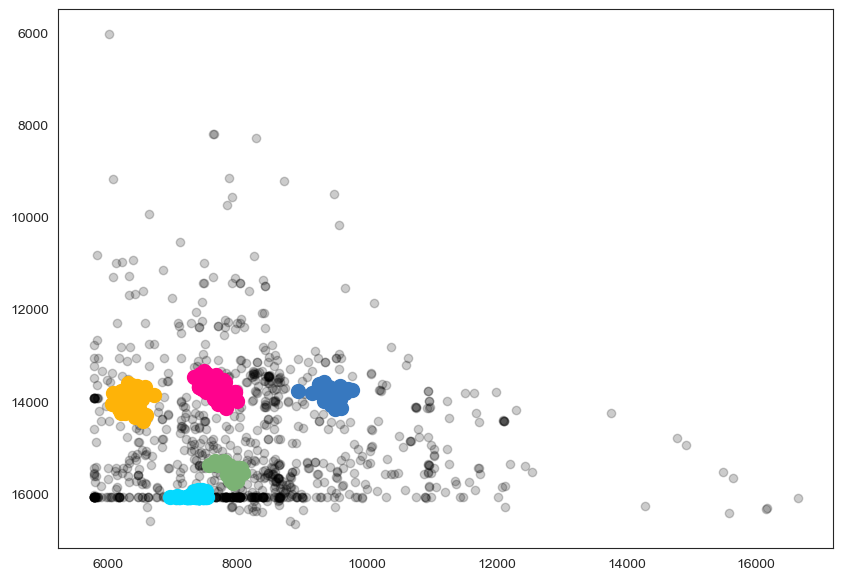

In [20]:
colors = ["windows blue", "amber", "hot pink", "faded green", "neon blue"]
colors = sns.xkcd_palette(colors)
plt.figure(figsize=(10,7))
plt.gca().invert_yaxis()
rest_data = data[~data.c.isin(top5.index)]
plt.scatter(rest_data.five, rest_data.three, c='black', alpha=0.2)
for (cluster, cdata), color in zip(data[data.c .isin(top5.index)].groupby('c'), colors):
    plt.scatter(cdata.five, cdata.three, c = color, s =100)

plt.savefig(figures_path/ '5top_clusters.svg')

In [21]:
cc = []
for (cluster, cdata), color in zip(data[data.c .isin(top5.index)].groupby('c'), ["windows blue", "amber", "hot pink", "faded green", "neon blue"]):
    print(f'{color} - {cdata.five.min()} - {cdata.three.max()}')

windows blue - 8933 - 14158
amber - 6063 - 14420
hot pink - 7322 - 14135
faded green - 7562 - 15761
neon blue - 6961 - 16080


In [22]:
data.to_csv(figures_path / '..'/ '3_Results'/'data_clusters.csv', index_label=None)


-------------
Delete the "hairpin":

In [23]:
counts, bins = np.histogram(breakpoints.three, bins=100)
counts, bins = np.histogram(breakpoints[(breakpoints.three > bins[np.argmax(counts)])&(breakpoints.three < bins[np.argmax(counts)+2])].three, bins=20)
breakpoints = breakpoints[
    (breakpoints.three < bins[np.argmax(counts)]) 
    | (breakpoints.three >  bins[np.argmax(counts)+2])]

# Clusters without the "hairpin":

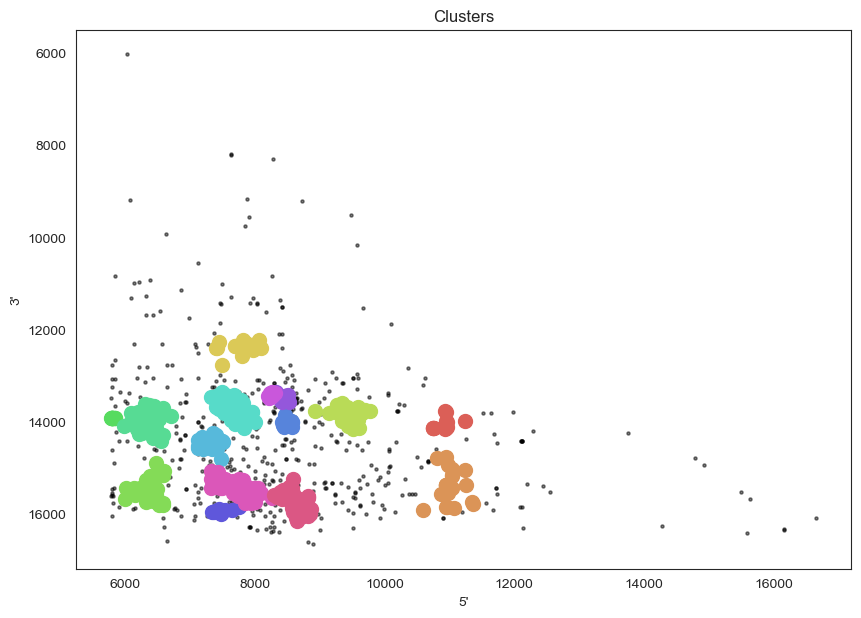

In [24]:
data2, clusters2 = clustering(breakpoints.copy(), str(figures_path / 'clusters.svg'))

In [25]:
data2['c'] = clusters2

cluster_stats = pd.concat([data2[data2.c >=0].groupby('c').mean(), data2[data2.c >=0].groupby('c').size()], axis=1)

cluster_stats.columns = ['five', 'three', 'size']

cluster_stats.to_csv(str(figures_path / '..'/ '3_Results'/ 'cluster_stats.csv'), index_label=None)

####  Statistics grouped by cluster
centers, number of elements

In [26]:
cluster_stats

five         three  size
c                                   
0   10906.083333  14036.916667    12
1   11008.304348  15406.130435    23
2    7771.266667  12376.466667    15
3    9449.875000  13827.406250    32
4    6387.931034  15437.310345    29
5    5802.181818  13922.727273    11
6    6377.600000  13954.750000    60
7    7642.093023  13696.395349    43
8    7309.777778  14487.666667    18
9    8502.600000  14017.500000    10
10   7486.888889  15924.666667     9
11   8460.000000  13465.800000    15
12   8248.222222  13413.000000     9
13   7762.509804  15456.254902    51
14   8619.678571  15743.232143    56

In [27]:
top5 = data2[data2.c >=0].c.value_counts().sort_values(ascending = False)[:5]

In [28]:
top5

6     60
14    56
13    51
7     43
3     32
Name: c, dtype: int64

### Figure 2B. Top 5 clusters of deletions.

/var/folders/zs/11_d9tgx0495nq5hmmxwdl0c0000gn/T/ipykernel_42852/1977634396.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cdata.five, cdata.three, c = color, s=70, alpha=0.4)


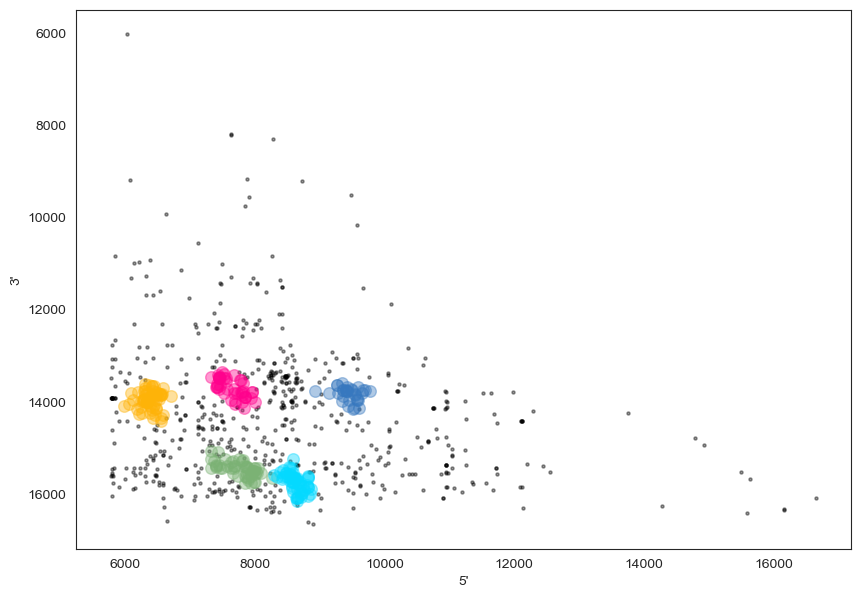

In [29]:
colors = ["windows blue", "amber", "hot pink", "faded green", "neon blue"]
colors = sns.xkcd_palette(colors)
plt.figure(figsize=(10,7))
plt.gca().invert_yaxis()


rest_data = data2[~data2.c.isin(top5.index)]
plt.scatter(rest_data.five, rest_data.three, c='black', alpha=0.4, s=5)
for (cluster, cdata), color in zip(data2[data2.c .isin(top5.index)].groupby('c'), colors):
    plt.scatter(cdata.five, cdata.three, c = color, s=70, alpha=0.4)
plt.xlabel("5'")
plt.ylabel("3'")

plt.savefig(figures_path/ '5top_clusters_no_spike.svg')

#### Plots all clusters for supplementary:

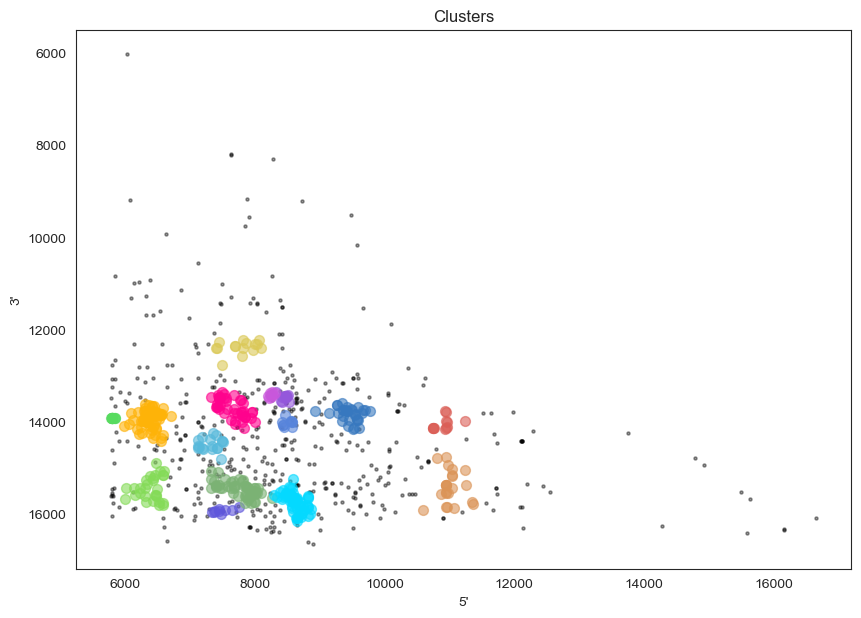

In [30]:
colors2 = sns.color_palette('hls', len(np.unique(clusters2))-1)
for i in np.arange(5):
    colors2[top5.index.sort_values().to_list()[i]] = colors[i]
sns.set_style('white')
plt.figure(figsize=(10,7))
plt.gca().invert_yaxis()
x = data2.five[clusters2 == -1]
y = data2.three[clusters2 == -1]
plt.scatter(x, y, color='black', alpha=0.4, s=5)

for c, color in list(zip(range(0, np.max(clusters2)+1), colors2)):
    x = data2.five[clusters2 == c]
    y = data2.three[clusters2 == c]
    plt.scatter(x, y, color=color, s=50, alpha=0.6)
plt.xlabel("5'")
plt.ylabel("3'")
plt.title('Clusters')
plt.savefig( figures_path/ 'clusters_5_colours2_no_spike.svg')

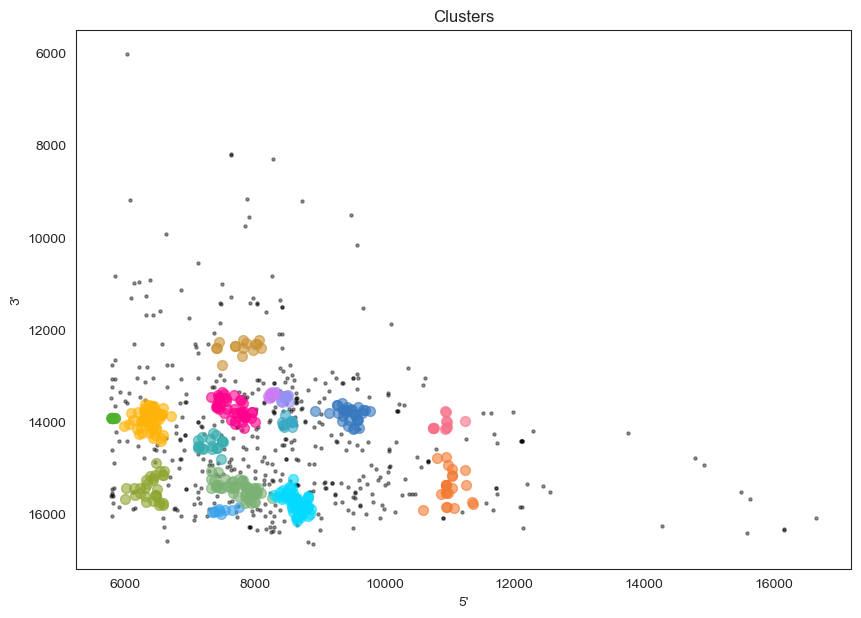

In [31]:
colors3 = sns.color_palette('husl', len(np.unique(clusters2))-1)
for i in np.arange(5):
    colors3[top5.index.sort_values().to_list()[i]] = colors[i]
sns.set_style('white')
plt.figure(figsize=(10,7))
plt.gca().invert_yaxis()
x = data2.five[clusters2 == -1]
y = data2.three[clusters2 == -1]
plt.scatter(x, y, color='black', alpha=0.4, s=5)

for c, color in list(zip(range(0, np.max(clusters2)+1), colors3)):
    x = data2.five[clusters2 == c]
    y = data2.three[clusters2 == c]
    plt.scatter(x, y, color=color, s=50, alpha=0.6)
plt.xlabel("5'")
plt.ylabel("3'")
plt.title('Clusters')
plt.savefig( figures_path/ 'clusters_5_colours3_no_spike.svg')

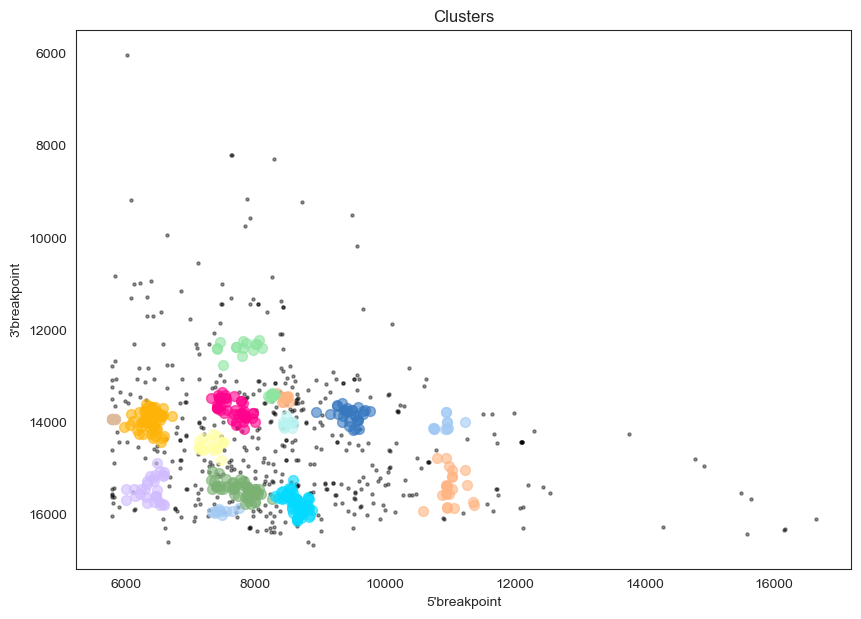

In [32]:
colors4 = sns.color_palette('pastel', len(np.unique(clusters2))-1)
for i in np.arange(5):
    colors4[top5.index.sort_values().to_list()[i]] = colors[i]
sns.set_style('white')
plt.figure(figsize=(10,7))
plt.gca().invert_yaxis()
x = data2.five[clusters2 == -1]
y = data2.three[clusters2 == -1]
plt.scatter(x, y, color='black', alpha=0.4, s=5)

for c, color in list(zip(range(0, np.max(clusters2)+1), colors4)):
    x = data2.five[clusters2 == c]
    y = data2.three[clusters2 == c]
    plt.scatter(x, y, color=color, s=50, alpha=0.6)
plt.xlabel("5'breakpoint")
plt.ylabel("3'breakpoint")
plt.title('Clusters')
plt.savefig( figures_path/ 'clusters_5_colours_no_spike.svg')

In [33]:
for c,name in zip(colors,["windows blue", "amber", "hot pink", "faded green", "neon blue"]):
    print(f'{name} - {int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}')

windows blue - 55, 120, 191
amber - 254, 179, 8
hot pink - 255, 2, 141
faded green - 123, 178, 116
neon blue - 4, 217, 255


In [34]:
cc = []
for (cluster, cdata), color in zip(data2[data2.c .isin(top5.index)].groupby('c'), ["windows blue", "amber", "hot pink", "faded green", "neon blue"]):
    print(f'{color} - {cdata.five.min()} - {cdata.three.max()}')

windows blue - 8933 - 14158
amber - 5978 - 14420
hot pink - 7322 - 14135
faded green - 7322 - 15761
neon blue - 8298 - 16143


#### Plots clusters separately:

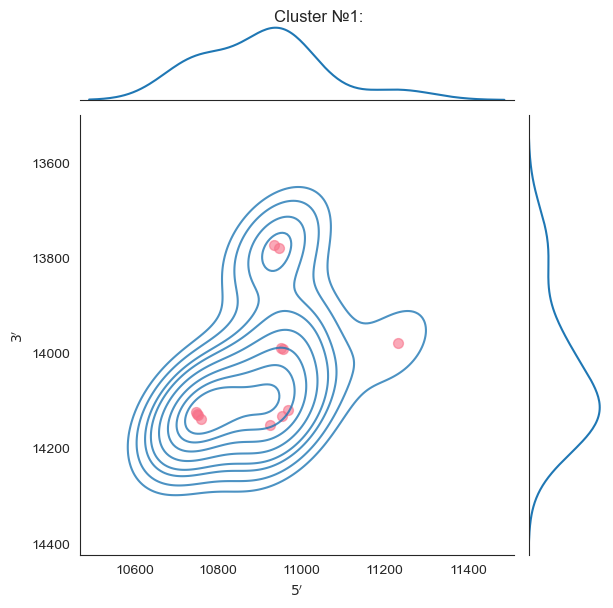

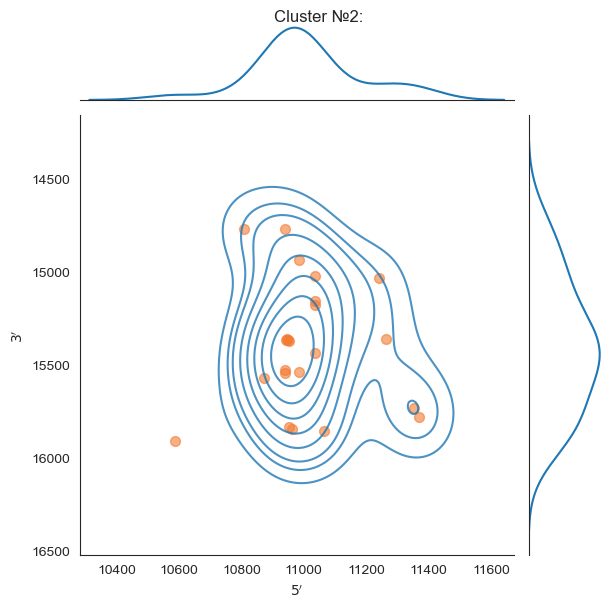

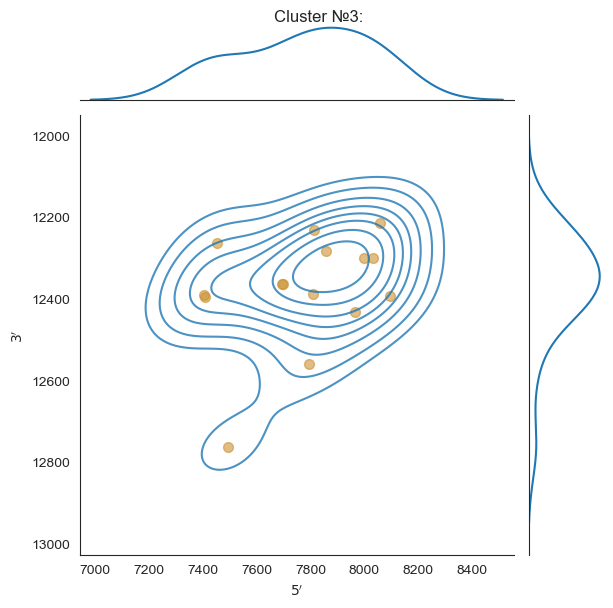

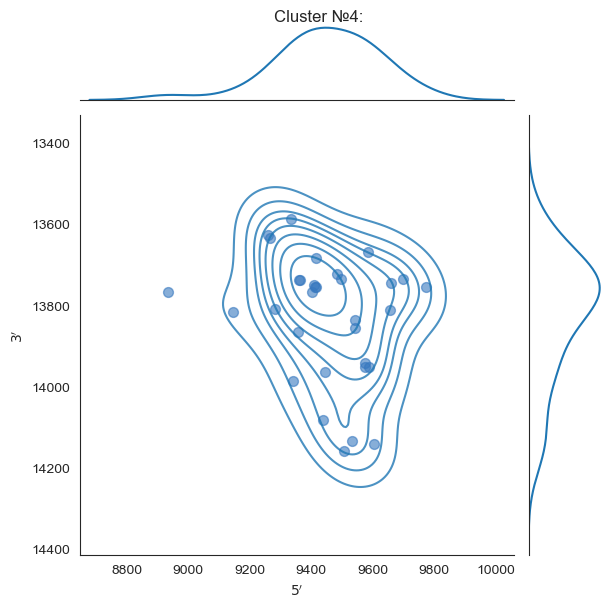

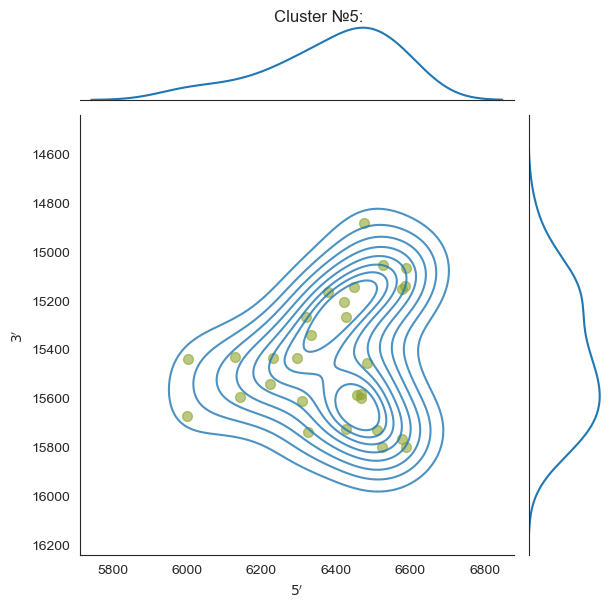

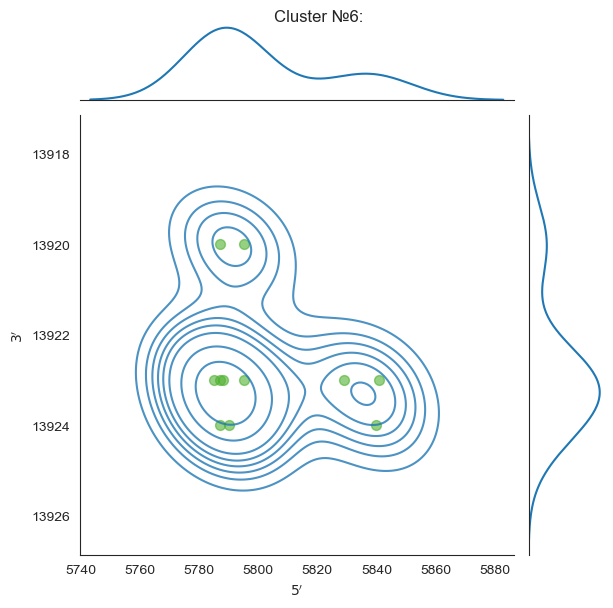

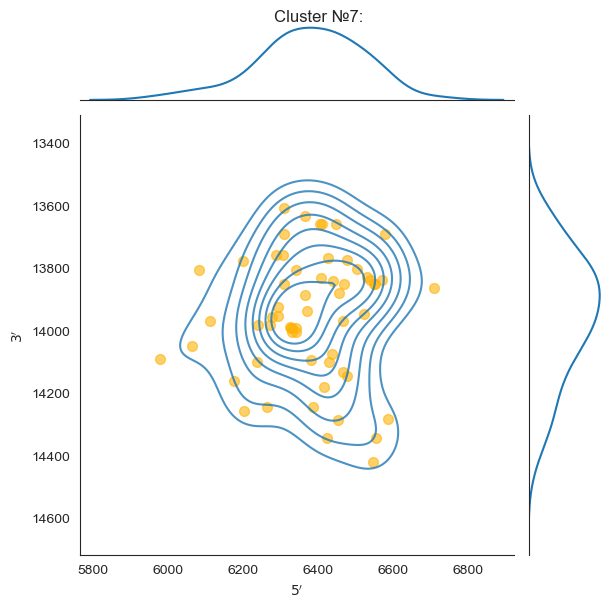

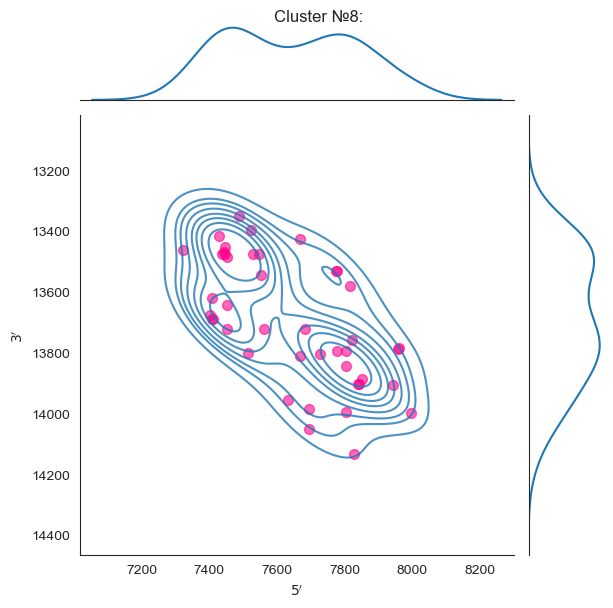

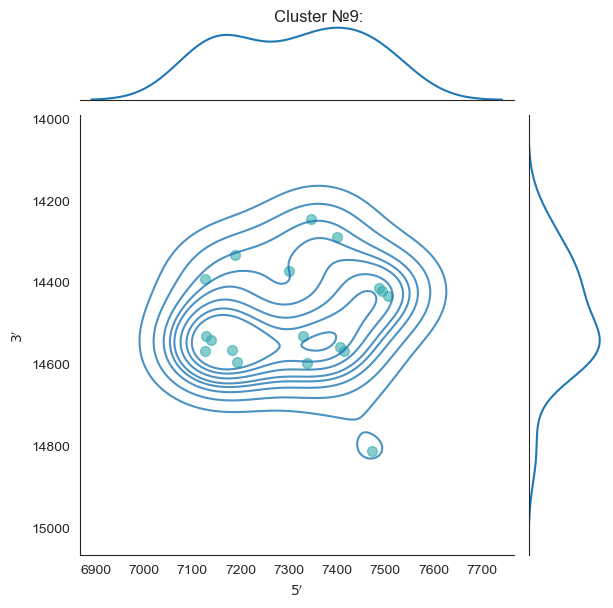

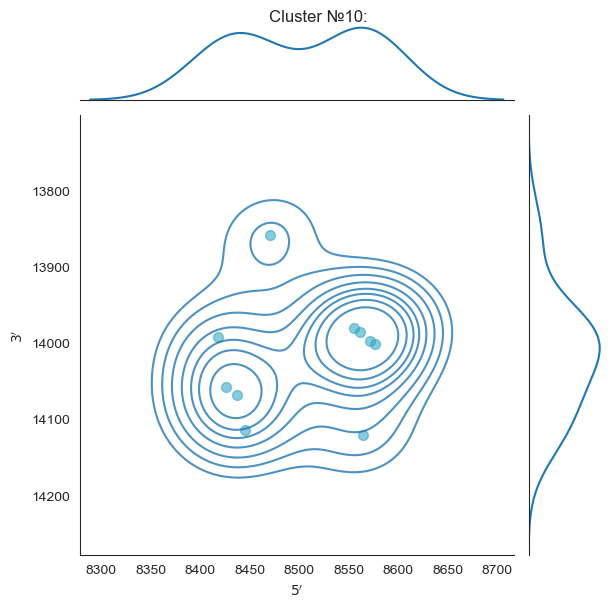

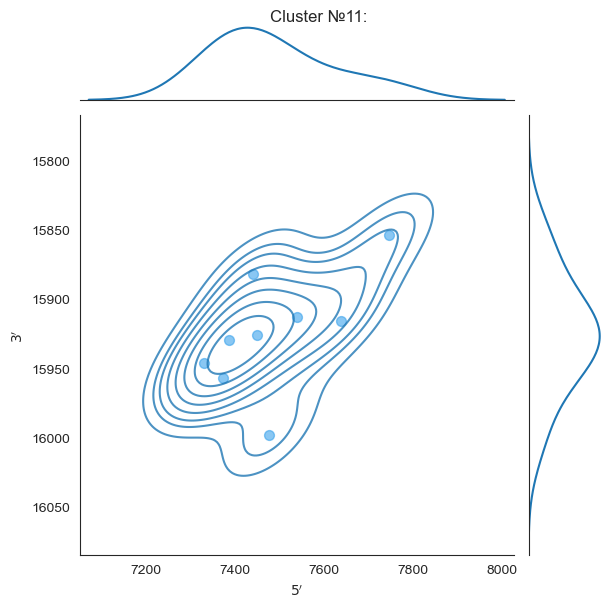

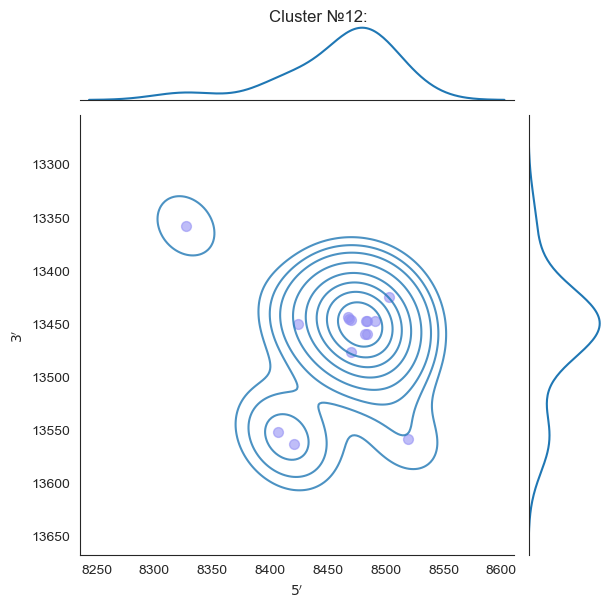

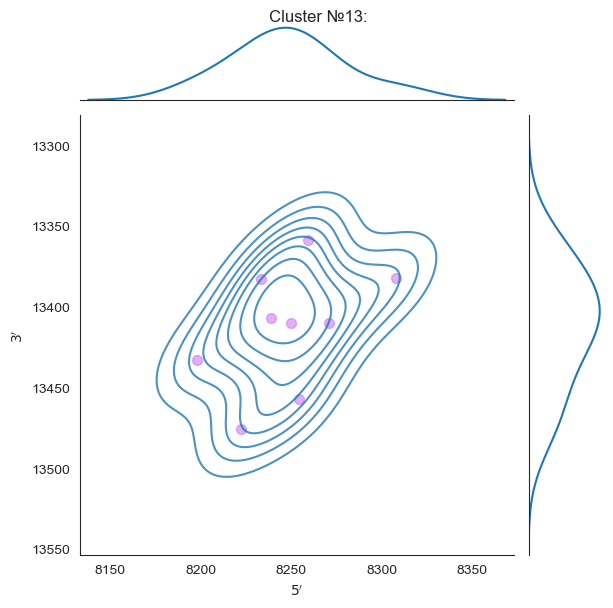

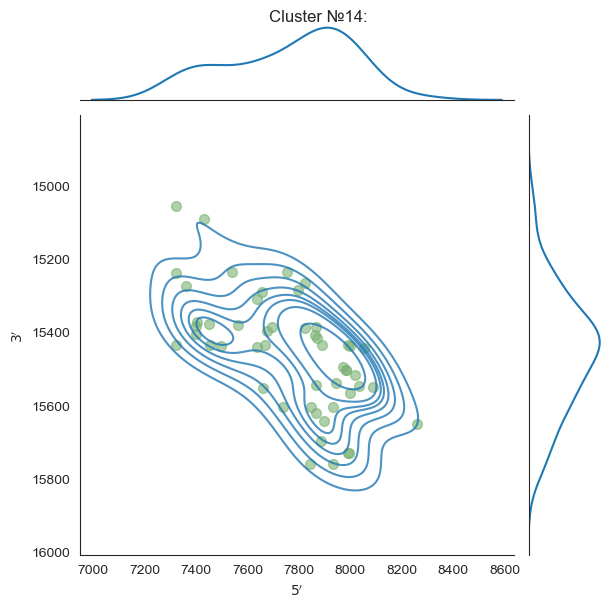

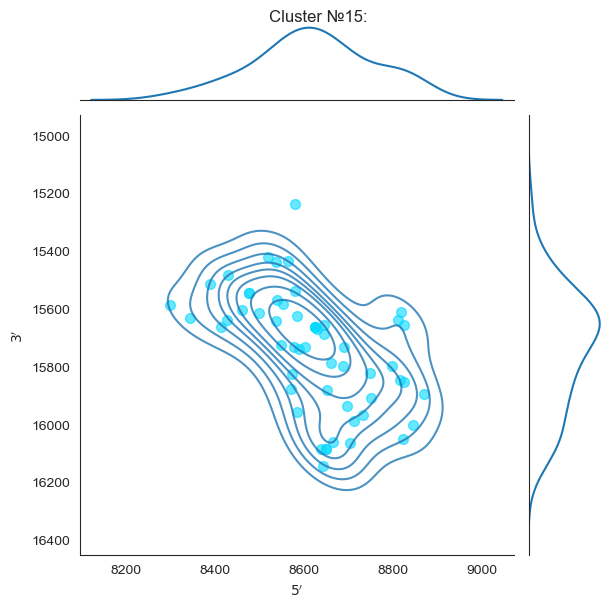

In [35]:
for c, color in list(zip(range(0, np.max(clusters2)+1), colors3)):
    cluster_data = data2[clusters2 == c]    
    
#     f, ax = plt.subplots(figsize=(6, 6))
#     sns.kdeplot(cluster_data.five, cluster_data.three, ax=ax)
#     #sns.jointplot(cluster_data.five, cluster_data.three, ax=ax)
#     sns.rugplot(cluster_data.five, color="g", ax=ax)
#     sns.rugplot(cluster_data.three, vertical=True, ax=ax);
    g = sns.jointplot(x="five", y="three",
                      data=cluster_data, kind="kde",
                      alpha=0.8)
    g.ax_joint.invert_yaxis()
    g.plot_joint(plt.scatter, color=color, s=50, alpha=0.6)
    g.ax_joint.collections[0].set_alpha(0)
    g.set_axis_labels("$5'$", "$3'$")    
    g.fig.suptitle('Cluster №{}:'.format(c+1), y= 1)
    plt.show()
    


### Save results

In [36]:
data.to_csv(figures_path / '..'/ '3_Results'/'data_clusters_no_spike.csv', index_label=None)

In [37]:
%watermark

Last updated: 2023-04-02T20:57:08.088984+02:00

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.7.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.3.0
Machine     : arm64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [38]:
%watermark -iv

numpy     : 1.24.2
matplotlib: 3.7.1
hdbscan   : 0.8.29
pandas    : 1.5.3
seaborn   : 0.12.2

